# Airfoil optimization

In [1]:
from IPython.display import SVG, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from torch.distributions import Normal


from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from functools import partial

#stuff for neurofoil - pip install neuralfoil
import shutil
import numpy as np

import sys
import os
import contextlib
from collections import deque
import copy

import warnings
import pennylane as qml

import multiprocessing as mp
from multiprocessing import Pool, Lock, Value
import subprocess
import matplotlib.pyplot as plt
import subprocess

from scipy.optimize import differential_evolution
import pandas as pd
import json
print(os.getcwd())

/home/student.unimelb.edu.au/reissmannm/test_shape_op/ShapeOptimization


In [2]:
id_ = 1 
glock = mp.Lock()

def get_id(lock):
    global id_
    with lock:
        id_ += 1
    return id_

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

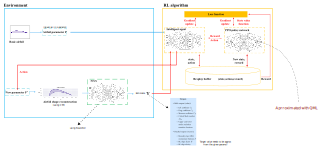

In [3]:
display(SVG(filename="optimprocedure.svg"))

save fig


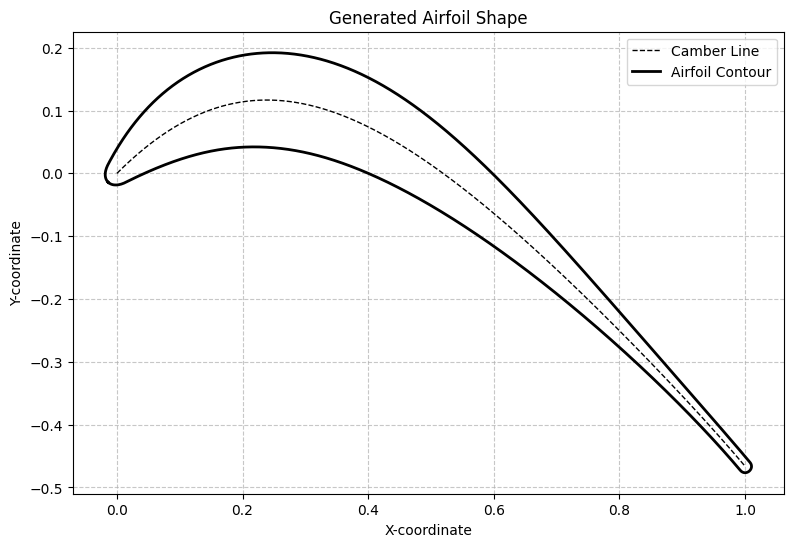

In [4]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil as ca
airfoil_top_points, airfoil_bottom_points, camber_curve_points = ca.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [5]:
# Starting with to adjustable params:
# NetworkA -> ChordLength + MaxThickness - using black box function to translate this into our parametrization
config_ = ca.load_config("../blade_design_tools/airfoil_config.yaml")

In [6]:
config_

{'camber_line': {'control_points_params': {'P1_k_factor': 0.4,
   'P2_x': 0.5,
   'P2_y': 0.05,
   'P3_k_factor': -0.25},
  'inlet_angle_deg': 45,
  'outlet_angle_deg': -50,
  'stagger_angle_deg': -25},
 'top_thickness': {'control_points_params': {'P1_k_factor': 0.2,
   'P2_x': 0.1,
   'P2_y': 0.03,
   'P3_k_factor': 0},
  'inlet_angle_deg': 40,
  'outlet_angle_deg': 0,
  'le_y_thickness': 0.02,
  'p4_y': 0.01},
 'bottom_thickness': {'control_points_params': {'P1_k_factor': 0.2,
   'P2_x': 0.1,
   'P2_y': 0.03,
   'P3_k_factor': 0},
  'inlet_angle_deg': 40,
  'outlet_angle_deg': 0,
  'le_y_thickness': 0.02,
  'p4_y': 0.01},
 'output_settings': {'output_airfoil_filename': 'None',
  'output_camber_filename': 'None',
  'output_top_thickness_filename': 'None',
  'output_bottom_thickness_filename': 'None',
  'plot_title': 'Generated Airfoil Shape',
  'num_points_on_curve': 1000,
  'num_points_on_arc': 50,
  'chord_length_for_export': 50.0}}

# Refine AC with PPO 
- Refine the critic -> going to GRPO
- trating the proplem as sequenze generation with sparse rewards

In [8]:
# Global lock for ID generation
glock = Lock()
id_counter = 0

def get_id(lock):
    global id_counter
    with lock:
        id_counter += 1
        return id_counter

# Configuration
action_idx = {
    1: ["camber_line", "control_points_params", "P1_k_factor", (0.15, 0.5)],
    2: ["camber_line", "control_points_params", "P3_k_factor", (-0.3, -0.1)],
    3: ["top_thickness", "control_points_params", "P1_k_factor", (0.15, 0.4)],
    4: ["top_thickness", "le_y_thickness", (0.01, 0.04)]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# EXTERNAL EVALUATION
# ============================================================================

@torch.no_grad()
def external_eval(trajectory, run_id, plot_foil=False):
    """
    Evaluate a trajectory (n actions) -> later on modifying up to 10 ?
    """
    actions = trajectory.cpu().numpy()
    
    subprocess.run(
        ["python", "uptake/external_eval.py", 
         json.dumps(actions.tolist()), 
         str(run_id), 
         str(plot_foil)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    
    try:
        loss = float(np.loadtxt(f"uptake/test{run_id}/loss.dat"))
        if loss <= 0:
            reward = -10.0
        else:
            reward = min(100.0, 1.0 / loss)
    except Exception as e:
        loss = -1.0
        reward = -10.0
    
    return reward, loss


def eval_trajectory_wrapper(args):
    """Wrapper for parallel evaluation"""
    trajectory, run_id, plot_foil = args
    reward, loss = external_eval(trajectory, run_id, plot_foil)
    return reward, loss, run_id


# ============================================================================
# ACTOR NETWORK - Autoreg.
# ============================================================================

class AutoregressiveActor(nn.Module):
    """
    Autoregressive policy that generates actions one at a time,
    conditioning each action on the previous ones.
    """
    def __init__(self, action_dim=4, hidden_dim=128, state_dim=3):
        super(AutoregressiveActor, self).__init__()
        self.action_dim = action_dim
        self.state_dim = state_dim
        
        # Encoder for state (episode context)
        self.state_encoder = nn.Sequential(
            nn.Linear(state_dim, hidden_dim // 2),
            nn.ReLU()
        )
        
        # LSTM for autoregressive generation
        self.lstm = nn.LSTM(
            input_size=1,  # Previous action value
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )
        
        # Output head for mean and log_std
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # mean and log_std
        )
        
    def forward(self, state, previous_actions=None):
        """
        Generate action distribution conditioned on state and previous actions
        """
        batch_size = state.shape[0]
        
        # Encode state
        state_embed = self.state_encoder(state)  # [batch, hidden_dim//2]
        
        # Process previous actions with LSTM
        if previous_actions is None or previous_actions.shape[1] == 0:
            # No previous actions - use zero hidden state
            lstm_out = torch.zeros(batch_size, self.lstm.hidden_size).to(state.device)
        else:
            # Run LSTM on previous actions
            prev_actions_input = previous_actions.unsqueeze(-1)  # [batch, seq_len, 1]
            lstm_output, _ = self.lstm(prev_actions_input)
            lstm_out = lstm_output[:, -1, :]  # Take last output
        
        # Combine state and LSTM output
        combined = torch.cat([state_embed, lstm_out], dim=-1)
        
        # Generate mean and log_std
        output = self.output_head(combined)
        mean = output[:, 0]
        log_std = torch.clamp(output[:, 1], -20, 2)
        std = log_std.exp()
        
        return mean, std
    
    def sample_trajectory(self, state):
        """
        Sample a complete trajectory autoregressively _ not assuming marcovian prop
        """
        batch_size = state.shape[0]
        trajectory = []
        log_probs = []
        
        previous_actions = torch.empty(batch_size, 0).to(state.device)
        
        for step in range(self.action_dim):
            # Get distribution for next action
            mean, std = self.forward(state, previous_actions)
            dist = distributions.Normal(mean, std)
            
            # Sample action
            action = dist.sample()
            log_prob = dist.log_prob(action)
            
            trajectory.append(action)
            log_probs.append(log_prob)
            
            # Update previous actions
            previous_actions = torch.cat([previous_actions, action.unsqueeze(1)], dim=1)
        
        trajectory = torch.stack(trajectory, dim=1)  # [batch, action_dim]
        log_probs = torch.stack(log_probs, dim=1)    # [batch, action_dim]
        
        return trajectory, log_probs
    
    def get_log_prob(self, state, trajectory):
        """
        Compute log probability of a given trajectory
        """
        batch_size = state.shape[0]
        log_probs = []
        
        previous_actions = torch.empty(batch_size, 0).to(state.device)
        
        for step in range(self.action_dim):
            mean, std = self.forward(state, previous_actions)
            dist = distributions.Normal(mean, std)
            
            action = trajectory[:, step]
            log_prob = dist.log_prob(action)
            log_probs.append(log_prob)
            
            previous_actions = torch.cat([previous_actions, action.unsqueeze(1)], dim=1)
        
        log_probs = torch.stack(log_probs, dim=1)
        return log_probs
    
    def get_entropy(self, state):
        """Compute entropy averaged over trajectory"""
        batch_size = state.shape[0]
        entropies = []
        
        previous_actions = torch.empty(batch_size, 0).to(state.device)
        
        for step in range(self.action_dim):
            mean, std = self.forward(state, previous_actions)
            dist = distributions.Normal(mean, std)
            entropy = dist.entropy()
            entropies.append(entropy)
            previous_actions = torch.cat([previous_actions, mean.unsqueeze(1)], dim=1)
        
        entropies = torch.stack(entropies, dim=1).mean(dim=1)
        return entropies


# ============================================================================
# CRITIC NETWORK
# ============================================================================

class Critic(nn.Module):
    """Value function for state evaluation"""
    def __init__(self, state_dim=3, hidden_dim=128):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)
        return self.network(state).squeeze(-1)


class qCritic(nn.Module):
    """Quantum value function using variational quantum circuit"""
    def __init__(self, state_dim=3, n_qubits=None, n_layers=3):
        super(qCritic, self).__init__()
        
        self.n_qubits = n_qubits if n_qubits is not None else max(10, state_dim)
        self.state_dim = state_dim
        
        # Classical input layer to map state to qubit dimension
        self.input_layer = nn.Linear(state_dim, self.n_qubits)
        
        # Create quantum device
        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        
        # Define quantum circuit
        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def quantum_circuit(inputs, weights):
            # Angle embedding of input features
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            
            # Variational quantum circuit with n_layers
            for layer in range(n_layers):
                # Rotation gates on each qubit
                for qubit in range(self.n_qubits):
                    qml.RX(weights[layer, qubit, 0], wires=qubit)
                    qml.RY(weights[layer, qubit, 1], wires=qubit)
                    qml.RZ(weights[layer, qubit, 2], wires=qubit)
                
                # Entangling layer
                for qubit in range(self.n_qubits - 1):
                    qml.CNOT(wires=[qubit, qubit + 1])
                
                # Ring topology
                if self.n_qubits > 2:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
            
            # Measure expectation values
            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        # Initialize quantum weights (n_layers x n_qubits x 3 rotations)
        weight_shapes = {"weights": (n_layers, self.n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.output_layer = nn.Linear(self.n_qubits, 1)
        self.relu = nn.ReLU()
    
    def forward(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)
            squeeze_output = True
        else:
            squeeze_output = False
        # Map state to qubit dimension
        x = self.relu(self.input_layer(state))  # [batch_size, n_qubits]
        
        # Normalize to [-π, π] for angle embedding
        x = torch.tanh(x) * np.pi
        quantum_out = self.quantum_layer(x)  # [batch_size, n_qubits]
        value = self.output_layer(quantum_out)  # [batch_size, 1]
        
        if squeeze_output:
            return value.squeeze()
        else:
            return value.squeeze(-1)
    
    
# ============================================================================
# GRPO TRAINING
# ============================================================================

def train_grpo(
    actor, 
    critic,
    external_eval_func,
    num_episodes=1000,
    group_size=64,  # Number of trajectories to sample per update
    lr_actor=1e-4,
    lr_critic=1e-3,
    gamma=0.99,
    clip_ratio=0.2,
    grpo_epochs=4,
    baseline_type='group_mean',  # 'group_mean', 'critic', or 'both'
    entropy_coef=0.01,
    value_loss_coef=0.5
):
    """
    GRPO Training Loop => do sim. things like llm opt. sample under sparse reward assumption 
    """
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)
    
    episode_rewards_hist = []
    episode_rewards = []
    best_reward = -float('inf')
    best_trajectory = None
    
    for episode in range(num_episodes):
        print(f"\n{'='*60}")
        print(f"Episode {episode + 1}/{num_episodes}")
        print(f"{'='*60}")
        
        # ====================================================================
        # 1. SAMPLE GROUP OF TRAJECTORIES
        # ====================================================================
        
        # State represents episode context
        # [best_reward_so_far, episode_progress, exploration_temperature]
        state = torch.tensor([
            min(best_reward / 10.0, 10.0) if best_reward > -float('inf') else 0.0,
            episode / num_episodes,
            max(0.1, 1.0 - episode / num_episodes)  # Decay exploration
        ], dtype=torch.float32).to(device)
        
        # Repeat state for batch sampling
        states = state.unsqueeze(0).repeat(group_size, 1)
        
        with torch.no_grad():
            trajectories, log_probs = actor.sample_trajectory(states)
            values = critic(states)
        
        # Sum log probs across trajectory steps for total log prob
        total_log_probs = log_probs.sum(dim=1)  # [group_size]
        
        print(f"Sampled {group_size} trajectories")
        print(f"Trajectory shape: {trajectories.shape}")
        
        # ====================================================================
        # 2. EVALUATE ALL TRAJECTORIES IN PARALLEL
        # ====================================================================
        
        ids = [get_id(glock) for _ in range(group_size)]
        eval_args = [(trajectories[i], ids[i], False) for i in range(group_size)]
        
        with Pool(processes=min(30, group_size)) as pool:
            results = pool.map(eval_trajectory_wrapper, eval_args)
        
        rewards = torch.tensor([r[0] for r in results], dtype=torch.float32)
        losses = [r[1] for r in results]
        
        print(f"\nRewards Statistics:")
        print(f"  Mean:   {rewards.mean().item():.4f}")
        print(f"  Median: {rewards.median().item():.4f}")
        print(f"  Std:    {rewards.std().item():.4f}")
        print(f"  Min:    {rewards.min().item():.4f}")
        print(f"  Max:    {rewards.max().item():.4f}")
        
        # Track best trajectory
        best_idx = rewards.argmax().item()
        if rewards[best_idx].item() > best_reward:
            best_reward = rewards[best_idx].item()
            best_trajectory = trajectories[best_idx].clone()
            print(f"New best reward: {best_reward:.4f}")
            print(f"Trajectory: {best_trajectory.cpu().numpy()}")
            print(f"Loss: {losses[best_idx]:.6f}")
        
        # ====================================================================
        # 3. COMPUTE ADVANTAGES (GROUP-RELATIVE)
        # ====================================================================
        
        # GRPO: Use group statistics as baseline
        if baseline_type == 'group_mean':
            baseline = rewards.mean()
            advantages = rewards - baseline
        elif baseline_type == 'critic':
            baseline = values
            advantages = rewards.to(device) - baseline
        elif baseline_type == 'both':
            group_baseline = rewards.mean()
            critic_baseline = values
            baseline = 0.5 * (group_baseline + critic_baseline)
            advantages = rewards.to(device) - baseline
        else:
            raise ValueError(f"Unknown baseline_type: {baseline_type}")
        
        # Normalize advantages for stability
        if advantages.std() > 1e-8:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute returns for critic (can use actual rewards or advantage + value)
        returns = rewards.to(device)
        
        # ====================================================================
        # 4. PPO-STYLE POLICY UPDATE (with GRPO advantages)
        # ====================================================================
        
        trajectories = trajectories.to(device)
        total_log_probs = total_log_probs.to(device)
        advantages = advantages.to(device)
        returns = returns.to(device)
        states = states.to(device)
        
        for epoch in range(grpo_epochs):
            # Shuffle data
            indices = torch.randperm(group_size)
            
            epoch_policy_loss = 0
            epoch_value_loss = 0
            epoch_entropy = 0
            
            for i in range(0, group_size, min(32, group_size)):
                batch_indices = indices[i:i+32]
                
                batch_states = states[batch_indices]
                batch_trajectories = trajectories[batch_indices]
                batch_old_log_probs = total_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                # Recompute log probs with current policy
                batch_log_probs_per_step = actor.get_log_prob(batch_states, batch_trajectories)
                batch_new_log_probs = batch_log_probs_per_step.sum(dim=1)
                
                # Policy loss with PPO clipping
                ratio = torch.exp(batch_new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Entropy bonus
                entropy = actor.get_entropy(batch_states).mean()
                policy_loss = policy_loss - entropy_coef * entropy
                
                # Value loss
                batch_values = critic(batch_states)
                value_loss = nn.MSELoss()(batch_values, batch_returns)
                
                # Update actor
                actor_optimizer.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
                actor_optimizer.step()
                
                # Update critic
                critic_optimizer.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
                critic_optimizer.step()
                
                epoch_policy_loss += policy_loss.item()
                epoch_value_loss += value_loss.item()
                epoch_entropy += entropy.item()
        
        # ====================================================================
        # 5. LOGGING
        # ====================================================================
        
        episode_reward = rewards.median().item()
        episode_rewards.append(episode_reward)
        episode_rewards_hist.append(rewards.numpy())
        
        
        
        if episode % 5 == 0:
            print(f"\nTraining Statistics:")
            print(f"  Policy Loss:  {epoch_policy_loss:.4f}")
            print(f"  Value Loss:   {epoch_value_loss:.4f}")
            print(f"  Entropy:      {epoch_entropy:.4f}")
            print(f"  Median Reward: {episode_reward:.4f}")
            
            if len(episode_rewards) >= 10:
                recent_mean = np.mean(episode_rewards[-10:])
                print(f"  Last 10 episodes avg: {recent_mean:.4f}")
    
    return actor, critic, episode_rewards_hist, best_trajectory

# AC - standard

In [ ]:
for seed in range(10):
    id_counter = 0
    np.random.seed(seed)
    torch.manual_seed(seed)

    state_dim = 3  # [best_reward_so_far, episode_progress, exploration_temp]
    action_dim = 4  # 4 design parameters
    
    actor = AutoregressiveActor(
        action_dim=action_dim,
        hidden_dim=128,
        state_dim=state_dim
    ).to(device)
    
    critic = Critic(
        state_dim=state_dim,
        hidden_dim=128
    ).to(device)
    
    print("="*60)
    print("GRPO Trajectory-Based Airfoil Optimization")
    print("="*60)
    print(f"Device: {device}")
    print(f"State dim: {state_dim}")
    print(f"Action dim: {action_dim}")
    print(f"Actor parameters: {sum(p.numel() for p in actor.parameters())}")
    print(f"Critic parameters: {sum(p.numel() for p in critic.parameters())}")
    
    # Train
    trained_actor, trained_critic, rewards_history, best_traj = train_grpo(
        actor=actor,
        critic=critic,
        external_eval_func=external_eval,
        num_episodes=50,
        group_size=64,
        lr_actor=1e-4,
        lr_critic=1e-3,
        gamma=0.99,
        clip_ratio=0.2,
        grpo_epochs=4,
        baseline_type='critic',
        entropy_coef=0.01,
        value_loss_coef=0.5
    )
    
    # Save final model
    torch.save({
        'actor_state_dict': trained_actor.state_dict(),
        'critic_state_dict': trained_critic.state_dict(),
        'best_trajectory': best_traj,
        'rewards_history': rewards_history
    }, 'grpo_final_model.pt')
    
    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60)
    print(f"Best trajectory: {best_traj.cpu().numpy()}")
    print(f"Final model saved to: grpo_final_model.pt")
    os.system(f"mkdir seed_t{seed}")
    os.system(f"mv uptake/test* seed_t{seed}/")
    os.system(f"mv grpo_final_model.pt seed_t{seed}/")

GRPO Trajectory-Based Airfoil Optimization
Device: cpu
State dim: 3
Action dim: 4
Actor parameters: 224386
Critic parameters: 17153

Episode 1/50
Sampled 64 trajectories
Trajectory shape: torch.Size([64, 4])

Rewards Statistics:
  Mean:   0.4021
  Median: -10.0000
  Std:    14.6433
  Min:    -10.0000
  Max:    25.0626
New best reward: 25.0626
Trajectory: [ 0.67893696  0.33563328 -0.5475093   0.5372116 ]
Loss: 0.039900

Training Statistics:
  Policy Loss:  -0.1111
  Value Loss:   422.4576
  Entropy:      2.4624
  Median Reward: -10.0000

Episode 2/50
Sampled 64 trajectories
Trajectory shape: torch.Size([64, 4])

Rewards Statistics:
  Mean:   0.5569
  Median: -10.0000
  Std:    13.9366
  Min:    -10.0000
  Max:    25.3957
New best reward: 25.3957
Trajectory: [ 0.34392083 -0.9872      0.01744958  0.07173752]
Loss: 0.039377

Episode 3/50
Sampled 64 trajectories
Trajectory shape: torch.Size([64, 4])

Rewards Statistics:
  Mean:   -1.2553
  Median: -10.0000
  Std:    12.9253
  Min:    -10.00

# AC - with quantum

In [ ]:
for seed in range(10):
    id_counter = 0
    np.random.seed(seed)
    torch.manual_seed(seed)

    state_dim = 3  # [best_reward_so_far, episode_progress, exploration_temp]
    action_dim = 4  # 4 design parameters
    
    actor = AutoregressiveActor(
        action_dim=action_dim,
        hidden_dim=128,
        state_dim=state_dim
    ).to(device)
    
    critic = qCritic(
        state_dim=state_dim
    ).to(device)
    
    print("="*60)
    print("GRPO Trajectory-Based Airfoil Optimization")
    print("="*60)
    print(f"Device: {device}")
    print(f"State dim: {state_dim}")
    print(f"Action dim: {action_dim}")
    print(f"Actor parameters: {sum(p.numel() for p in actor.parameters())}")
    print(f"Critic parameters: {sum(p.numel() for p in critic.parameters())}")
    
    # Train
    trained_actor, trained_critic, rewards_history, best_traj = train_grpo(
        actor=actor,
        critic=critic,
        external_eval_func=external_eval,
        num_episodes=50,
        group_size=64,
        lr_actor=1e-4,
        lr_critic=1e-3,
        gamma=0.99,
        clip_ratio=0.2,
        grpo_epochs=4,
        baseline_type='critic',
        entropy_coef=0.01,
        value_loss_coef=0.5
    )
    
    # Save final model
    torch.save({
        'actor_state_dict': trained_actor.state_dict(),
        'critic_state_dict': trained_critic.state_dict(),
        'best_trajectory': best_traj,
        'rewards_history': rewards_history
    }, 'grpo_final_model.pt')
    
    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60)
    print(f"Best trajectory: {best_traj.cpu().numpy()}")
    print(f"Final model saved to: grpo_final_model.pt")
    os.system(f"mkdir seed_t{seed}")
    os.system(f"mv uptake/test* seed_t{seed}/")
    os.system(f"mv grpo_final_model.pt seed_t{seed}/")